In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn import metrics

We will now assess our 3 models to determine which has performed best on our test set. First we will choose what metrics to evaluate by for our data and then we will compare them using the chosen metrics.

#### Evaluation metrics

Hard to choose good metrics for measuring performance.

For example, a common metric is `accuracy` which is the `number of correct predictions / total number of predictions`. However if our dataset is unbalanced, or we weight the correct predictions of one class more this metric will not give us a good idea of performance.

Another common choice looking at `precision` & `recall`, however because we value the predictions of both our classes equally and `precision` & `recall` do not look at the `true negative rate` which is valuable information for us to see how the model performs on the "negative" class

A good visual metric is the `confusion matrix` which will give us a 2x2 grid of the number of `TPs, FPs, FNs` and `TNs`. From this we can also derive other useful metrics.

So in order to ensure we use all values of our `confusion matrix` I will use `specificity` instead of `precision` which will tell us the proportion of of correct "negative" class predictions. I will also use `recall` (also known as `sensitivity`) to tell us the proportion of correct "positive" class predictions.

As for this problem, the weight given to the correct prediction of each class is the same. It is useful to try combine `sensitivity` and `specificity` into a single metric which we will try to maximize. This will be the Area under the curve (`AUC`) of a `ROC curve` - which is a graph that plots the `sensitivity` and `specificity` for different thresholds. We can use the `ROC curve` to plot our performance metrics and see which peforms better, we can even change the decision threshold to choose the most optimum operating point

In [23]:
def evaluation_metrics(X_test, y_true, model, thresh=0.5, plot=True):    
     
    """
    For a given model and test data, will return
    a set of metrics to measure model performance.
        
    For plot=True will return an ROC curve
    
    Inputs:
        y_true: pd.DataFrame / np.array - containing ground truth values
        y_pred: pd.DataFrame / np.array - containing predicted values
        model: sklearn model to predict with
        
    Outputs:
        eval_metrics: dict - Set of metrics: (precision, specificity, sensitivity, roc_auc_score, confusion matrix)
    """
    
    y_pred_proba = model.predict_proba(X_test)[::,1]
    
    y_pred = np.where(y_pred_proba > thresh, 1., 0.)
    
    # Calculate confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    
    # Use outputs for calculating later metrics
    tn = cm[0][0] # True negatives
    fn = cm[1][0] # False negatives
    tp = cm[1][1] # True positives
    fp = cm[0][1] # False positives

    eval_metrics = {}
        
    eval_metrics['sensitivity'] = tp/(tp+fn)
    eval_metrics['specificity'] = tn/(tn+fp)
    eval_metrics['roc_auc_score'] = metrics.roc_auc_score(y_true, y_pred_proba)
    eval_metrics['confusion_matrix'] = cm
    
    if plot:
        
        fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
        auc = eval_metrics['roc_auc_score']
        plt.plot(fpr,tpr,label="AUC="+str(np.round(auc,3)))
        plt.title('ROC-AUC curve')
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.legend(loc=4)
        plt.show()
    
    return eval_metrics

#### Model comparisons:

Let's read in our test data and models:

In [52]:
X_test_minmax = np.load('data/test_data.npy')
y_test = np.load('data/test_labels.npy')

X_test_minmax = np.load('data/data_test.npy')
y_test = np.load('data/labels_test.npy')

X_test_CB = pd.read_csv('data/test_data_cat.csv')
y_test_CB = pd.read_csv('data/test_labels_cat.csv')

XGBoost = pickle.load(open('models/XGBoost-2023-01-20.pkl', 'rb'))
CBoost = pickle.load(open('models/CBoost-2023-01-20.pkl', 'rb'))
RFclf = pickle.load(open('models/RF-2023-01-18.pkl', 'rb'))

## `XGBoost`:

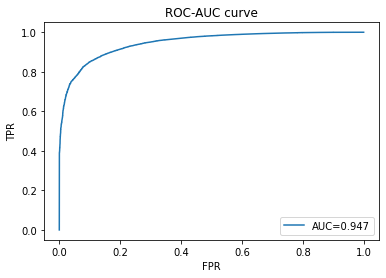

{'sensitivity': 0.8578374796956485,
 'specificity': 0.8895893954089881,
 'roc_auc_score': 0.9469214089715637,
 'confusion_matrix': array([[ 5503,   683],
        [13303, 80273]])}

In [42]:
evaluation_metrics(X_test_minmax, y_test, XGBoost) 

## `CBoost`:

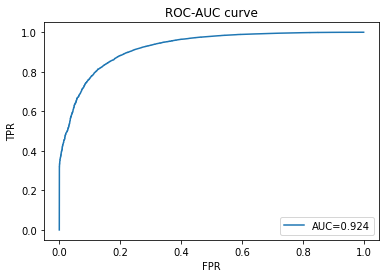

{'sensitivity': 0.8917030007694281,
 'specificity': 0.786291626252829,
 'roc_auc_score': 0.9239065757560202,
 'confusion_matrix': array([[ 4864,  1322],
        [10134, 83442]])}

In [53]:
evaluation_metrics(X_test_CB, y_test_CB, CBoost) 

## `Random Forest`:

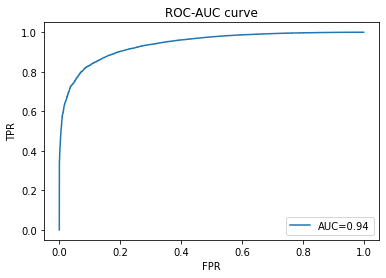

{'sensitivity': 0.9158438061041293,
 'specificity': 0.7691561590688651,
 'roc_auc_score': 0.9400039442274805,
 'confusion_matrix': array([[ 4758,  1428],
        [ 7875, 85701]])}

In [9]:
evaluation_metrics(X_test_minmax, y_test, RFclf) 

Can see that all the models perform similarly, however the `specificty` (or TNR) is higher in our `XGBoost` model and the total overall area under the curve (`AUC`) is also slightly higher, signifying that the model is overall a better classifier of both classes.